In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

from sklearn.ensemble import RandomForestRegressor


In [2]:
df = pd.read_csv("../datasets/spotify_data_cleaned.csv")

df = df.drop(columns=['is_dance_hit', 'is_any_outlier'], errors='ignore')

print(f"\nŠtevilo vrstic: {len(df)}")
print(f"Število stolpcev: {len(df.columns)}")

print("\nPrvih 5 vrstic podatkov:")
print(df.head())

print("\nInformacije o podatkovnem okviru:")
df.info()

print("\nStatistični povzetek numeričnih stolpcev:")
print(df.describe())


Število vrstic: 80293
Število stolpcev: 21

Prvih 5 vrstic podatkov:
   Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False  

In [3]:
numeric_cols = [
    'popularity', 'danceability', 'energy', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo'
]

duration = 'duration_ms'

binary_cols = ['explicit', 'mode']
categorical_cols = ['key', 'time_signature', 'track_genre']
text_cols = ['artists', 'album_name', 'track_name']

audio_features = ['danceability', 'energy', 'loudness',
                  'speechiness', 'acousticness', 'instrumentalness',
                  'liveness', 'valence']



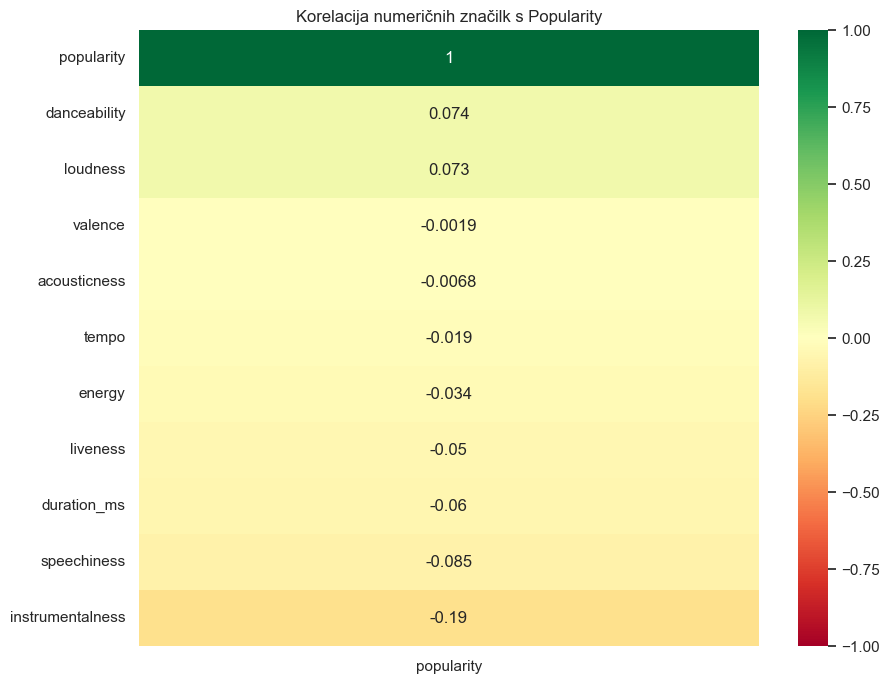

Tabela vpliva numeričnih spremenljivk na Popularity:
                  Korelacijski koeficient
popularity                       1.000000
danceability                     0.074163
loudness                         0.073137
valence                         -0.001856
acousticness                    -0.006825
tempo                           -0.019312
energy                          -0.034196
liveness                        -0.050307
duration_ms                     -0.060205
speechiness                     -0.085061
instrumentalness                -0.194921


In [4]:
# Izračun korelacije samo za numerične stolpce
plt.figure(figsize=(10, 8))
vsi_numericni = numeric_cols + [duration]
corr_matrix = df[vsi_numericni].corr()

# Heatmap, kjer gledamo vpliv na popularity
sns.heatmap(corr_matrix[['popularity']].sort_values(by='popularity', ascending=False),
            annot=True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title('Korelacija numeričnih značilk s Popularity')
plt.show()

# Izračun korelacij
corr_table = df[vsi_numericni].corr()['popularity'].sort_values(ascending=False).to_frame()
corr_table.columns = ['Korelacijski koeficient']

print("Tabela vpliva numeričnih spremenljivk na Popularity:")
print(corr_table)

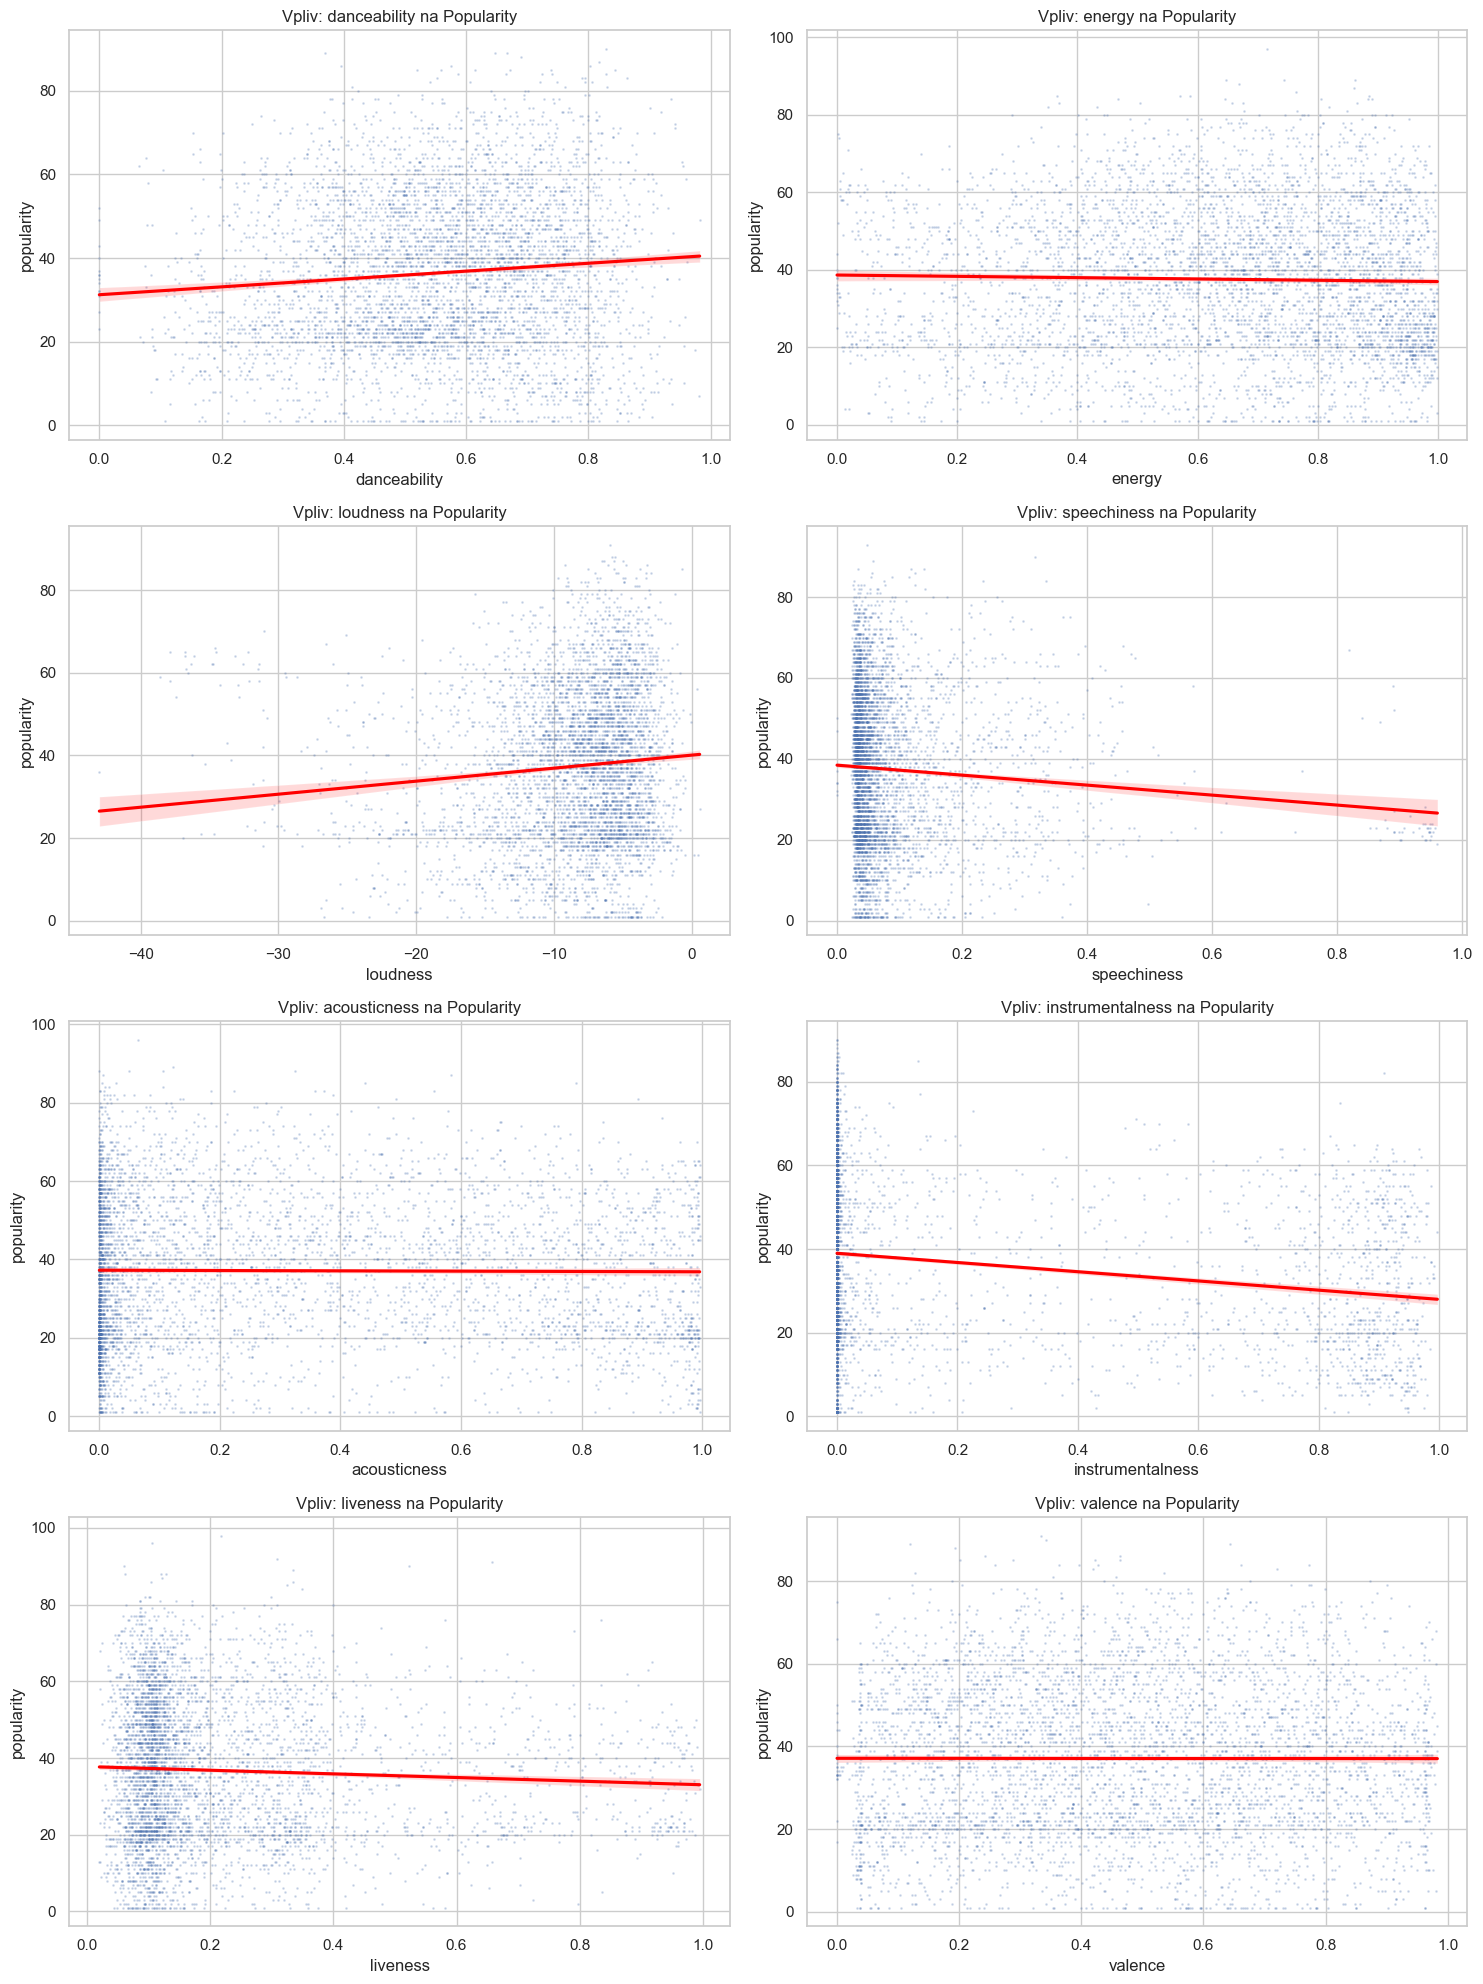

In [5]:
# Izris mrežnega grafa (4 vrstici, 2 stolpca)
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

for i, col in enumerate(audio_features):
    sns.regplot(data=df.sample(5000), x=col, y='popularity',
                scatter_kws={'alpha': 0.2, 's': 1}, line_kws={'color': 'red'}, ax=axes[i])
    axes[i].set_title(f'Vpliv: {col} na Popularity')

plt.tight_layout()
plt.show()


Primerjava popularnosti za binarne spremenljivke:
                        Avg. Pop.  Std. Odklon  Št. pesmi
Spremenljivka Vrednost                                   
explicit      False     36.737923    17.926700      73360
              True      40.987596    19.674951       6933


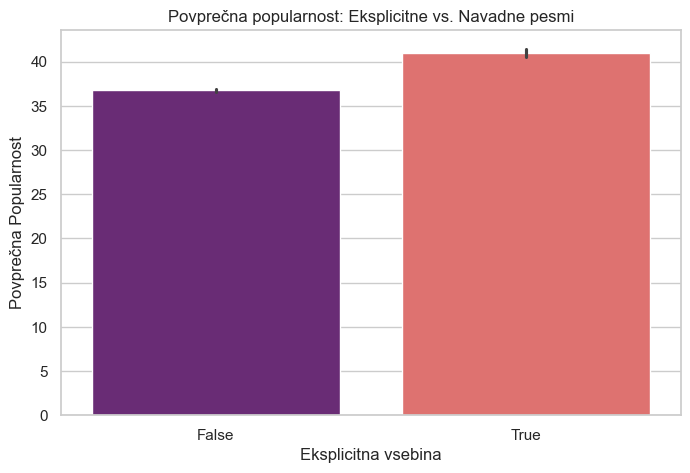

In [6]:
binary_summary = []
summary = df.groupby('explicit')['popularity'].agg(['mean', 'std', 'count']).reset_index()
summary['spremenljivka'] = 'explicit'
summary.columns = ['Vrednost', 'Avg. Pop.', 'Std. Odklon', 'Št. pesmi', 'Spremenljivka']
binary_summary.append(summary)

df_binary_res = pd.concat(binary_summary).set_index(['Spremenljivka', 'Vrednost'])
print("\nPrimerjava popularnosti za binarne spremenljivke:")
print(df_binary_res)

plt.figure(figsize=(8, 5))
sns.barplot(x='explicit', y='popularity', hue='explicit', data=df, palette='magma', legend=False)
plt.title('Povprečna popularnost: Eksplicitne vs. Navadne pesmi')
plt.ylabel('Povprečna Popularnost')
plt.xlabel('Eksplicitna vsebina')
plt.show()



Analiza popularnosti glede na dolžino pesmi:
              popularity
duration_cat            
<2min          30.456168
2-3min         37.867867
3-4min         39.620238
4-5min         37.664672
5-10min        32.552091
>10min         26.650943


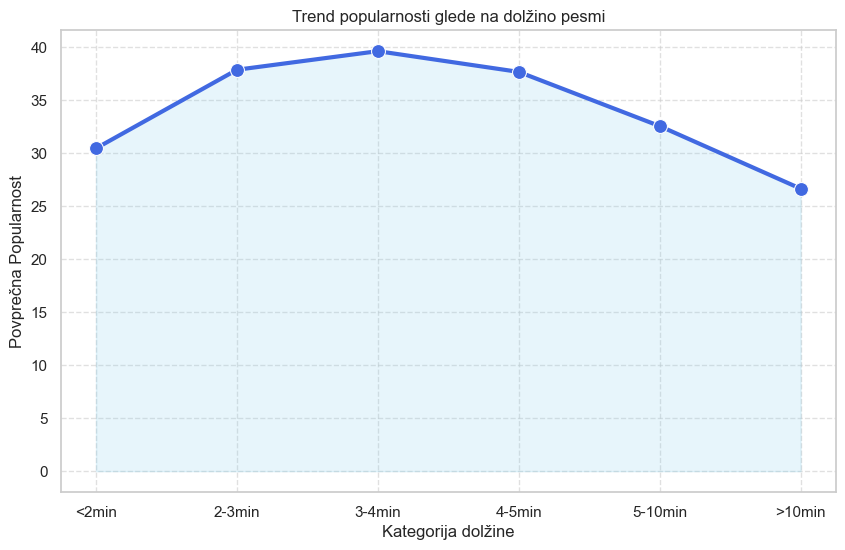

In [7]:
# Pretvorba v minute za lažjo interpretacijo
df['duration_min'] = df['duration_ms'] / 60000

# Razdelimo v skupine (npr. do 2 min, 2-3, 3-4, 4-5, 5+)
bins = [0, 2, 3, 4, 5, 10, 20]
labels = ['<2min', '2-3min', '3-4min', '4-5min', '5-10min', '>10min']
df['duration_cat'] = pd.cut(df['duration_min'], bins=bins, labels=labels)

duration_analysis = df.groupby('duration_cat', observed=True)['popularity'].mean().to_frame()
print("\nAnaliza popularnosti glede na dolžino pesmi:")
print(duration_analysis)

plt.figure(figsize=(10, 6))
sns.lineplot(x=duration_analysis.index.astype(str), y='popularity',
             data=duration_analysis, marker='o', markersize=10, color='royalblue', linewidth=3)
plt.fill_between(duration_analysis.index.astype(str), duration_analysis['popularity'], color="skyblue", alpha=0.2)
plt.title('Trend popularnosti glede na dolžino pesmi')
plt.ylabel('Povprečna Popularnost')
plt.xlabel('Kategorija dolžine')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


--- Analiza za stolpec: key ---
          mean  count
key                  
8    38.255285   4920
3    37.949299   2426
11   37.629537   6419
6    37.482312   5484
5    37.469518   6430
4    37.285758   6516
2    37.074817   8474
0    37.060941   9140
10   36.833936   5251
1    36.756880   7667
9    36.691640   8062
7    36.200863   9504


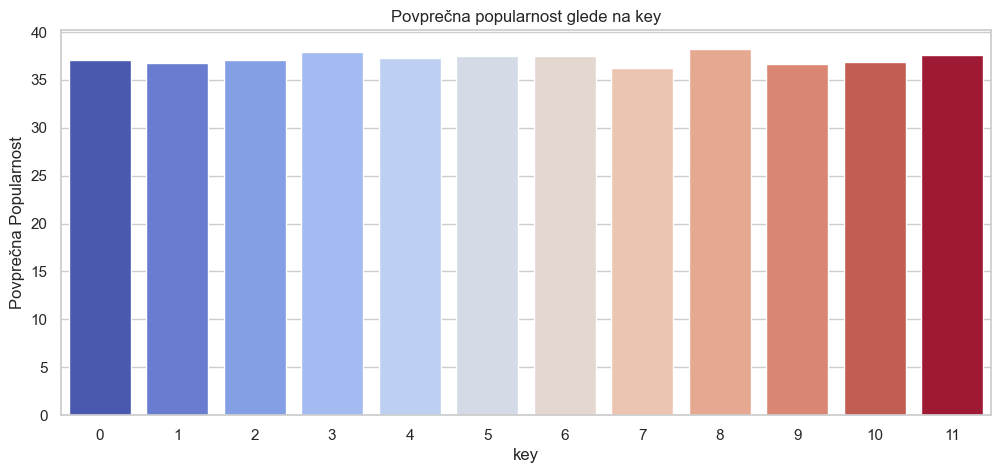


--- Analiza za stolpec: time_signature ---
                     mean  count
time_signature                  
0               37.867089    158
4               37.455551  71520
3               34.552434   6513
5               33.430037   1365
1               32.272727    737


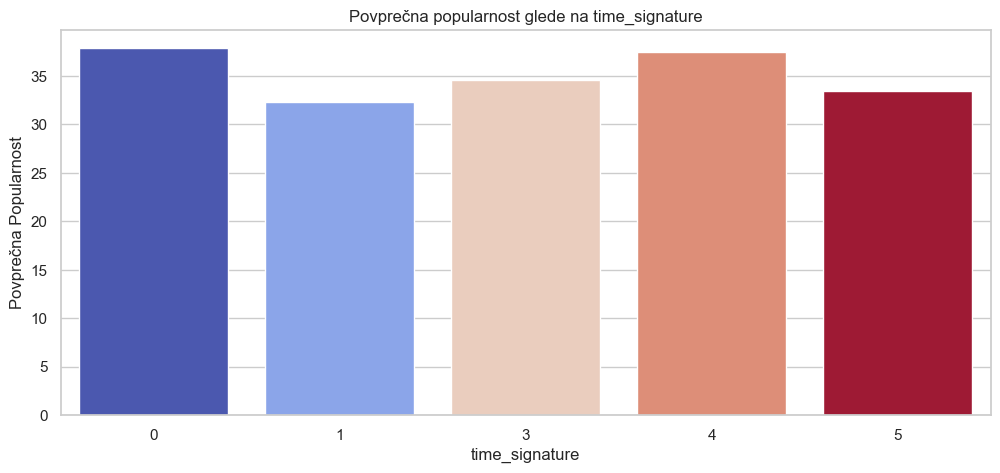


--- Analiza za stolpec: track_genre ---
Top 10 najbolj popularnih žanrov:
                  mean  count
track_genre                  
k-pop        59.684211    912
pop-film     59.242312    813
metal        57.920354    226
latino       57.575419    358
soul         57.217391    207
edm          57.042683    492
electro      56.994429    359
pop          56.469256    309
chill        55.925054    934
house        55.694215    121


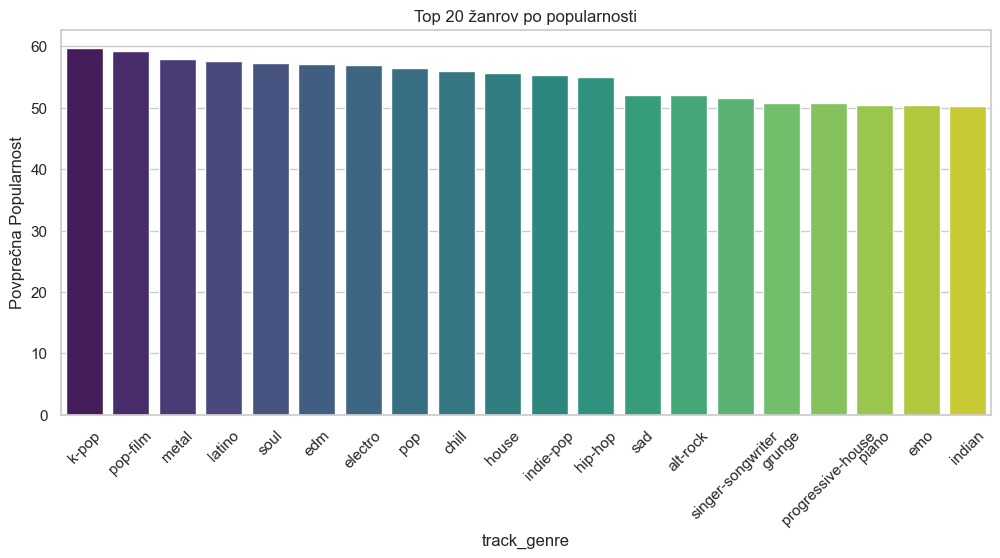

In [8]:
for col in categorical_cols:
    # Izračun povprečja in števila pesmi
    cat_analysis = df.groupby(col)['popularity'].agg(['mean', 'count']).sort_values(by='mean', ascending=False)

    print(f"\n--- Analiza za stolpec: {col} ---")
    if col == 'track_genre':
        print("Top 10 najbolj popularnih žanrov:")
        print(cat_analysis.head(10))
    else:
        print(cat_analysis)

    # Izris grafov
    plt.figure(figsize=(12, 5))

    if col == 'track_genre':
        # Za žanre narišemo le top 20, da je graf berljiv
        top_20 = cat_analysis.head(20)
        sns.barplot(x=top_20.index, y=top_20['mean'], hue=top_20.index, palette='viridis', legend=False)
        plt.xticks(rotation=45)
        plt.title(f'Top 20 žanrov po popularnosti')
    else:
        sns.barplot(x=cat_analysis.index, y=cat_analysis['mean'], hue=cat_analysis.index, palette='coolwarm',
                    legend=False)
        plt.title(f'Povprečna popularnost glede na {col}')

    plt.ylabel('Povprečna Popularnost')
    plt.show()

In [9]:

import pandas as pd
from scipy import stats


def is_normal(x, alpha=0.05):
    """Return (is_normal_bool, pvalue). Shapiro for n<=5000, D'Agostino otherwise."""
    x = np.asarray(x[~pd.isna(x)])
    if x.size < 3:
        return False, np.nan
    try:
        if x.size <= 5000:
            stat, p = stats.shapiro(x)
        else:
            stat, p = stats.normaltest(x)
        return (p > alpha), p
    except Exception:
        return False, np.nan


def choose_numeric_numeric_test(x, y, alpha=0.05):
    """Return chosen test name, stat, pvalue: Pearson if both normal, else Spearman."""
    ok_x, p_x = is_normal(x, alpha=alpha)
    ok_y, p_y = is_normal(y, alpha=alpha)
    pair = pd.DataFrame({'x': x, 'y': y}).dropna()
    if len(pair) < 3:
        return 'too_few', np.nan, np.nan
    if ok_x and ok_y:
        try:
            stat, p = stats.pearsonr(pair['x'], pair['y'])
            return 'pearson', stat, p
        except Exception:
            pass
    # fallback to Spearman
    try:
        stat, p = stats.spearmanr(pair['x'], pair['y'])
        return 'spearman', stat, p
    except Exception:
        return 'spearman_failed', np.nan, np.nan


def choose_cat_numeric_test(groups, alpha=0.05):
    """
    groups: list/iterable of arrays for each category
    Returns chosen test name, stat, pvalue, effect_estimate_placeholder
    """
    # require at least two groups
    if len(groups) < 2:
        return 'no_variation', np.nan, np.nan, np.nan

    # test normality per group
    normal_flags = []
    for g in groups:
        ok, _ = is_normal(np.asarray(g), alpha=alpha)
        normal_flags.append(ok)

    # Levene for homogeneity (works with >=2 groups)
    try:
        lev_stat, lev_p = stats.levene(*groups, center='median', nan_policy='omit')
        equal_var = (lev_p > alpha)
    except Exception:
        equal_var = False

    if len(groups) == 2:
        a, b = groups
        if all(normal_flags) and equal_var:
            try:
                tstat, tp = stats.ttest_ind(a, b, equal_var=True, nan_policy='omit')
                eff = (np.mean(a) - np.mean(b)) / np.sqrt(((a.var(ddof=1) + b.var(ddof=1)) / 2)) if (
                        len(a) > 1 and len(b) > 1) else np.nan
                return 't-test', tstat, tp, eff
            except Exception:
                pass
        # fallback nonparametric
        try:
            mstat, mp = stats.mannwhitneyu(a, b, alternative='two-sided')
            return 'mannwhitney', mstat, mp, np.nan
        except Exception:
            return 'mannwhitney_failed', np.nan, np.nan, np.nan
    else:
        # multi-group
        if all(normal_flags) and equal_var:
            try:
                fstat, fp = stats.f_oneway(*groups)
                return 'anova', fstat, fp, np.nan
            except Exception:
                pass
        try:
            kstat, kp = stats.kruskal(*groups)
            return 'kruskal', kstat, kp, np.nan
        except Exception:
            return 'kruskal_failed', np.nan, np.nan, np.nan

In [12]:
norm_ok, p_val = is_normal(df['popularity'])
print(f"Ali je popularnost normalno porazdeljena? {'DA' if norm_ok else 'NE'} (p = {p_val:.4f})")

Ali je popularnost normalno porazdeljena? NE (p = 0.0000)


Rezultat, da popularnost ni normalno porazdeljena, je ključen – to pomeni, da so neparametrični testi (Spearman, Kruskal-Wallis, Mann-Whitney) pravilna izbira.

In [13]:
results_final = []

# Seznam vseh neodvisnih spremenljivk (brez popularity in id-jev)
features = [col for col in df.columns if col not in ['popularity', 'track_id', 'artists', 'album_name', 'track_name']]

for feat in features:
    # 1. Numerične spremenljivke (npr. energy, danceability) -> KORELACIJA
    if pd.api.types.is_numeric_dtype(df[feat]) and df[feat].nunique() > 15:
        test_name, stat, p = choose_numeric_numeric_test(df[feat], df['popularity'])
        results_final.append({
            'Spremenljivka': feat, 'Test': test_name, 'Statistika': stat, 'p-vrednost': p
        })

    # 2. Kategorične/Diskretne (npr. genre, explicit, key) -> ANOVA/KRUSKAL
    else:
        # Pripravimo skupine za test
        groups = [group['popularity'].values for _, group in df.groupby(feat, observed=True)]

        test_name, stat, p, _ = choose_cat_numeric_test(groups)
        results_final.append({
            'Spremenljivka': feat, 'Test': test_name, 'Statistika': stat, 'p-vrednost': p
        })

# Pretvori v tabelo
df_stat_results = pd.DataFrame(results_final)
display(df_stat_results.sort_values('p-vrednost'))

,Spremenljivka,Test,Statistika,p-vrednost
15,track_genre,kruskal,3.846475e+04,0.000000e+00
10,instrumentalness,spearman,-1.973907e-01,0.000000e+00
17,duration_cat,kruskal,2.223784e+03,0.000000e+00
8,speechiness,spearman,-9.913620e-02,1.797307e-174
6,loudness,spearman,7.859916e-02,3.228466e-110
4,energy,spearman,-6.715348e-02,6.591230e-81
3,danceability,spearman,6.472235e-02,2.812530e-75
9,acousticness,spearman,5.900710e-02,7.336774e-63
2,explicit,mannwhitney,2.237791e+08,1.646153e-61
14,time_signature,kruskal,2.778130e+02,6.599390e-59


# Bivariatna analiza in izbor značilk - regresija (popularity)

Izvedli smo bivariatno analizo, kjer smo preverjali povezanost med neodvisnimi spremenljivkami in ciljno spremenljivko `popularity`. Zaradi ugotovitve, da ciljna spremenljivka ni normalno porazdeljena (), smo uporabili neparametrične teste: **Spearmanov korelacijski koeficient** za numerične spremenljivke ter **Kruskal-Wallisov** in **Mann-Whitney U test** za kategorične oziroma binarne spremenljivke.

### Pregled statističnih rezultatov:

| Test | Spremenljivke | Rezultat (r / stat) | p-vrednost | Interpretacija |
| --- | --- | --- | --- | --- |
| **Kruskal-Wallis** | `track_genre` | 38,464.7 | < 0.001 | Žanr je najmočnejši dejavnik priljubljenosti. |
| **Spearman** | `instrumentalness` | -0.197 | < 0.001 | Močan negativen vpliv; več inštrumentalnosti znižuje popularnost. |
| **Spearman** | `danceability` | +0.065 | < 0.001 | Pozitiven vpliv plesnosti na uspeh pesmi. |
| **Mann-Whitney** | `explicit` | 2.23e+08 | < 0.001 | Eksplicitne pesmi imajo značilno drugačno porazdelitev popularnosti. |
| **Spearman** | `valence` | -0.0015 | **0.669** | **Ni statistično značilne povezave.** |

### Izbor značilk (Feature Selection)

Na podlagi statistične analize smo se odločili za naslednji nabor neodvisnih spremenljivk:

* **Vključene numerične:** `danceability`, `energy`, `loudness`, `speechiness`, `acousticness`, `instrumentalness`, `liveness`, `tempo` in `duration_ms`.
* **Vključene kategorične/binarne:** `track_genre`, `explicit`, `mode`, `key` in `time_signature`.

**Utemeljitev izbora:**

1. **Izločitev `valence`:** Ker je p-vrednost () presegla prag značilnosti (), spremenljivka ne prispeva k pojasnjevanju varience popularnosti in bi v model vnašala le šum.
2. **Preprečevanje multikolinearnosti:** Izločili smo izpeljani spremenljivki `duration_min` in `duration_cat`, saj vsebinsko podvajata informacijo v `duration_ms`. Prav tako smo odstranili `Unnamed: 0`, ki predstavlja zgolj indeks baze.
3. **Zadržanje `track_genre`:** Kljub visoki kardinalnosti je žanr po Kruskal-Wallisovem testu daleč najpomembnejši prediktor.

### Transformacija podatkov za modeliranje

Da bodo podatki primerni za strojno učenje (zlasti za KNN in Linearno regresijo), bomo izvedli naslednje korake:

* **One-Hot Encoding:** Kategorične spremenljivke (`track_genre`, `key`, `time_signature`) bomo pretvorili v binarne (dummy) spremenljivke.
* **Skaliranje:** Vse numerične značilke bomo standardizirali z uporabo `StandardScaler` (povprečje 0, standardni odklon 1), da preprečimo prevlado spremenljivk z večjimi merskimi enotami (npr. `duration_ms` vs `danceability`).


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. Definiraj nabor značilk po bivariatni analizi (brez valence)
initial_features = [
    'duration_ms', 'explicit', 'danceability', 'energy', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'tempo', 'time_signature', 'track_genre', 'key'
]

X_initial = df[initial_features].copy()
y = df['popularity']

# 2. One-Hot Encoding za vse kategorične
X_initial = pd.get_dummies(X_initial, columns=['track_genre', 'key', 'time_signature'], drop_first=True)

# 3. Razdelitev
X_train_init, X_test_init, y_train, y_test = train_test_split(X_initial, y, test_size=0.2, random_state=42)

print(f"Začetna priprava končana. Število stolpcev: {X_train_init.shape[1]}")

Začetna priprava končana. Število stolpcev: 138


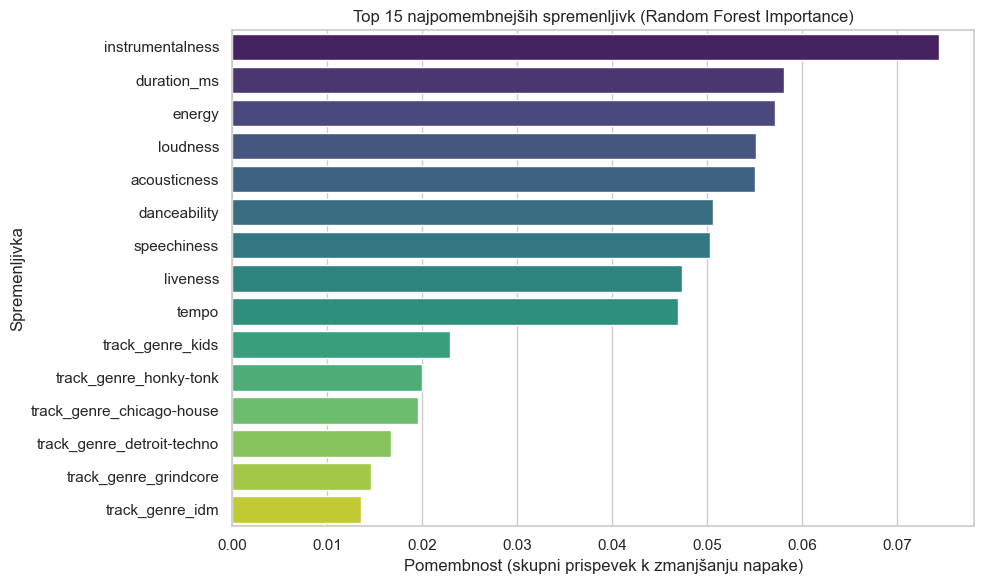

Najboljših 5 spremenljivk po Random Forest:
            feature  importance
8  instrumentalness    0.074388
0       duration_ms    0.058111
3            energy    0.057165
4          loudness    0.055123
7      acousticness    0.055009


In [45]:
# 1. Treniranje modela za ugotavljanje pomembnosti
rf_selector = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train_init, y_train)

# 2. Pridobivanje pomembnosti značilk
importances = rf_selector.feature_importances_
feature_names = X_train_init.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 3. Vizualizacija TOP 15 značilk
plt.figure(figsize=(10, 6))
top_15 = feature_importance_df.head(15)
sns.barplot(x='importance', y='feature', hue='feature', data=top_15, palette='viridis', legend=False)
plt.title('Top 15 najpomembnejših spremenljivk (Random Forest Importance)')
plt.xlabel('Pomembnost (skupni prispevek k zmanjšanju napake)')
plt.ylabel('Spremenljivka')
plt.tight_layout()
plt.show()

# 4. Izpis prvih nekaj najboljših
print("Spremenljivke po Random Forest:")
print(feature_importance_df)

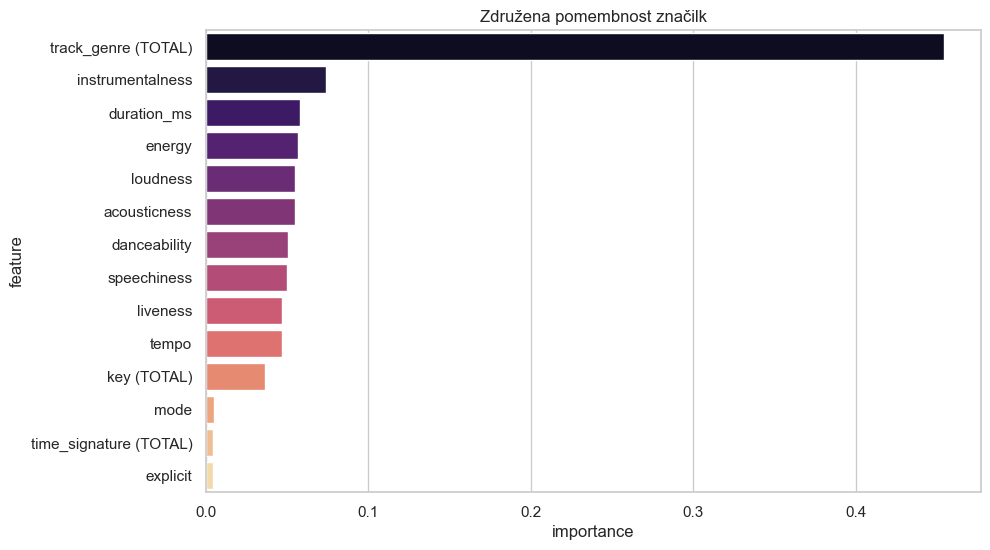

Pomembnost značilk:
                    feature  importance
11     track_genre (TOTAL)    0.453849
8         instrumentalness    0.074388
0              duration_ms    0.058111
3                   energy    0.057165
4                 loudness    0.055123
7             acousticness    0.055009
2             danceability    0.050591
6              speechiness    0.050348
9                 liveness    0.047331
10                   tempo    0.046958
12             key (TOTAL)    0.036550
5                     mode    0.005310
13  time_signature (TOTAL)    0.004827
1                 explicit    0.004439


In [17]:
# 1. Treniranje RF modela za oceno pomembnosti
rf_selector = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train_init, y_train)

# 2. Pridobivanje in združevanje pomembnosti
fi_df = pd.DataFrame({'feature': X_train_init.columns, 'importance': rf_selector.feature_importances_})

genre_mask = fi_df['feature'].str.startswith('track_genre_')
key_mask = fi_df['feature'].str.startswith('key_')
ts_mask = fi_df['feature'].str.startswith('time_signature_')

fi_grouped = fi_df[~genre_mask & ~key_mask & ~ts_mask].copy()
fi_grouped = pd.concat([fi_grouped, pd.DataFrame([
    {'feature': 'track_genre (TOTAL)', 'importance': fi_df.loc[genre_mask, 'importance'].sum()},
    {'feature': 'key (TOTAL)', 'importance': fi_df.loc[key_mask, 'importance'].sum()},
    {'feature': 'time_signature (TOTAL)', 'importance': fi_df.loc[ts_mask, 'importance'].sum()}
])], ignore_index=True).sort_values(by='importance', ascending=False)

# 3. Vizualizacija
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', hue='feature', data=fi_grouped, palette='magma', legend=False)
plt.title('Združena pomembnost značilk')
plt.show()

print("Pomembnost značilk:\n", fi_grouped)

In [5]:
# 1. Končni izbor (izločimo tiste s pomembnostjo < 0.01)
final_features = [
    'duration_ms', 'danceability', 'energy', 'loudness',
    'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'tempo', 'track_genre', 'key'
]

X_final = df[final_features].copy()

# 2. Končni One-Hot Encoding
X_final = pd.get_dummies(X_final, columns=['track_genre', 'key'], drop_first=True)

# 3. Končna razdelitev
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# 4. Končno skaliranje
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Končna priprava končana. Število značilk: {X_train.shape[1]}")

Končna priprava končana. Število značilk: 132


In [6]:
import optuna
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer
import numpy as np
import pandas as pd

# Izklopimo nepotrebne izpise Optune za čisto kodo
optuna.logging.set_verbosity(optuna.logging.WARNING)


# Funkcija za MAPE
def mape_func(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


mape_scorer = make_scorer(mape_func, greater_is_better=False)


def mape_func2(y_true, y_pred, threshold=10):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Only calculate MAPE for songs with popularity >= threshold
    mask = y_true >= threshold

    if mask.sum() == 0:  # Safety check
        return np.nan

    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


mape_scorer2 = make_scorer(mape_func2, greater_is_better=False, threshold=10)


In [21]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

best_models = {"Linear Regression": LinearRegression()}


# --- OPTIMIZACIJA RIDGE ---
def ridge_objective(trial):
    alpha = trial.suggest_float('alpha', 0.01, 1000.0, log=True)
    model = Ridge(alpha=alpha)
    score = cross_validate(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    return -score['test_score'].mean()


print("Optimiziram Ridge (Bayesian)...")
study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(ridge_objective, n_trials=20)
best_models["Ridge (Optimized)"] = Ridge(**study_ridge.best_params)


# --- OPTIMIZACIJA KNN ---
def knn_objective(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 25)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights)
    score = cross_validate(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    return -score['test_score'].mean()


print("Optimiziram KNN (Bayesian)...")
study_knn = optuna.create_study(direction='minimize')
study_knn.optimize(knn_objective, n_trials=15)
best_models["KNN (Optimized)"] = KNeighborsRegressor(**study_knn.best_params)


# --- OPTIMIZACIJA RANDOM FOREST ---
def rf_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 25),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'random_state': 42, 'n_jobs': -1
    }
    model = RandomForestRegressor(**params)
    score = cross_validate(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    return -score['test_score'].mean()


print("Optimiziram Random Forest (Bayesian)...")
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(rf_objective, n_trials=15)
best_models["Random Forest (Optimized)"] = RandomForestRegressor(**study_rf.best_params, random_state=42)


# --- OPTIMIZACIJA XGBOOST ---
def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 42, 'n_jobs': -1
    }
    model = XGBRegressor(**params)
    score = cross_validate(model, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    return -score['test_score'].mean()


print("Optimiziram XGBoost (Bayesian)...")
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(xgb_objective, n_trials=20)
best_models["XGBoost (Optimized)"] = XGBRegressor(**study_xgb.best_params, random_state=42)

print("Vsa optimizacija je zaključena!")

Optimiziram Ridge (Bayesian)...
Optimiziram KNN (Bayesian)...
Optimiziram Random Forest (Bayesian)...
Optimiziram XGBoost (Bayesian)...
Vsa optimizacija je zaključena!


In [23]:
import pickle

# Save after optimization
with open('best_models.pkl', 'wb') as f:
    pickle.dump(best_models, f)

# Load later
# with open('best_models.pkl', 'rb') as f:
#     best_models = pickle.load(f)
#
# print(best_models)

In [24]:
import json

# Extract and save parameters
params_dict = {
    "Ridge": study_ridge.best_params,
    "KNN": study_knn.best_params,
    "RF": study_rf.best_params,
    "XGBoost": study_xgb.best_params
}

with open('best_params.json', 'w') as f:
    json.dump(params_dict, f, indent=2)

# Load and recreate models
# with open('best_params.json', 'r') as f:
#     params = json.load(f)
#
# best_models = {
#     "Linear Regression": LinearRegression(),
#     "Ridge (Optimized)": Ridge(**params["Ridge"]),
#     "KNN (Optimized)": KNeighborsRegressor(**params["KNN"]),
#     "Random Forest (Optimized)": RandomForestRegressor(**params["RF"], random_state=42),
#     "XGBoost (Optimized)": XGBRegressor(**params["XGBoost"], random_state=42)
# }

In [25]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
final_results = []

print("Izvajam končno 10-fold navzkrižno preverjanje...")

for name, model in best_models.items():
    scores = cross_validate(
        model, X_train_scaled, y_train,
        cv=kf,
        scoring={
            'r2': 'r2',
            'mae': 'neg_mean_absolute_error',
            'rmse': 'neg_root_mean_squared_error',
            'mape': mape_scorer
        },
        n_jobs=-1
    )

    final_results.append({
        "Model": name,
        "R2 (mean ± SD)": f"{np.mean(scores['test_r2']):.3f} ± {np.std(scores['test_r2']):.3f}",
        "MAE (mean ± SD)": f"{np.abs(np.mean(scores['test_mae'])):.3f} ± {np.std(scores['test_mae']):.3f}",
        "RMSE (mean ± SD)": f"{np.abs(np.mean(scores['test_rmse'])):.3f} ± {np.std(scores['test_rmse']):.3f}",
        "MAPE % (mean ± SD)": f"{np.abs(np.mean(scores['test_mape'])):.2f}% ± {np.std(scores['test_mape']):.2f}"
    })

df_final_comparison = pd.DataFrame(final_results)
display(df_final_comparison)

Izvajam končno 10-fold navzkrižno preverjanje...


,Model,R2 (mean ± SD),MAE (mean ± SD),RMSE (mean ± SD),MAPE % (mean ± SD)
0,Linear Regression,0.449 ± 0.009,9.702 ± 0.086,13.422 ± 0.116,98.51% ± 7.66
1,Ridge (Optimized),0.449 ± 0.009,9.702 ± 0.086,13.422 ± 0.116,98.51% ± 7.66
2,KNN (Optimized),0.449 ± 0.014,9.313 ± 0.129,13.421 ± 0.209,82.76% ± 6.48
3,Random Forest (Optimized),0.388 ± 0.008,10.588 ± 0.108,14.145 ± 0.137,96.87% ± 7.12
4,XGBoost (Optimized),0.482 ± 0.016,8.913 ± 0.101,13.011 ± 0.206,85.58% ± 6.84


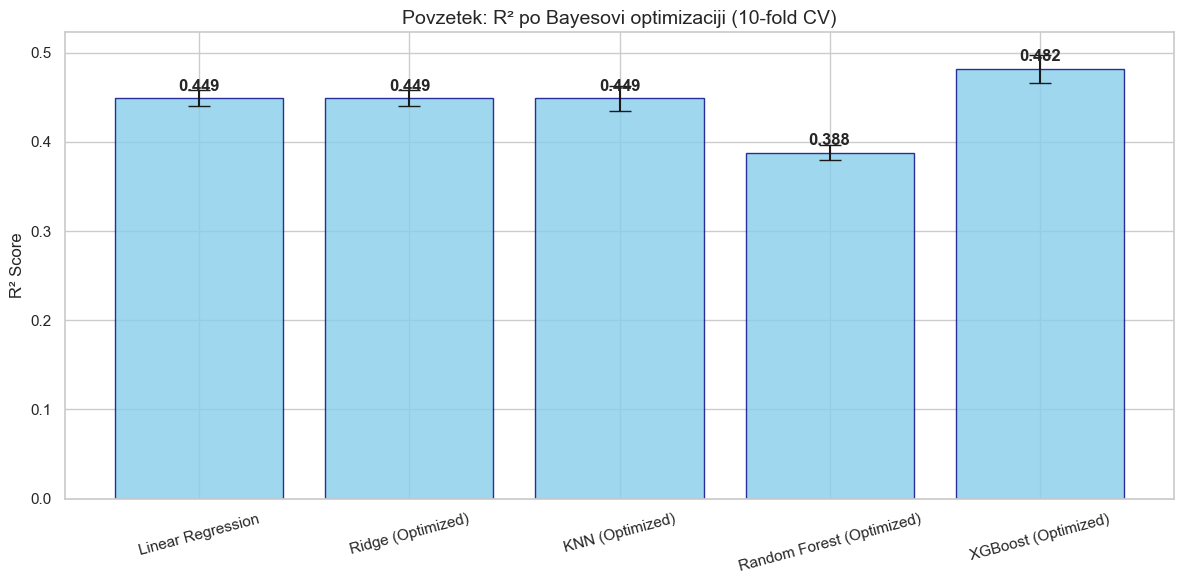

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Priprava podatkov
names = [r['Model'] for r in final_results]
r2_means = [float(r['R2 (mean ± SD)'].split(' ')[0]) for r in final_results]
r2_stds = [float(r['R2 (mean ± SD)'].split(' ')[2]) for r in final_results]

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
bars = plt.bar(names, r2_means, yerr=r2_stds, capsize=8, color='skyblue', edgecolor='navy', alpha=0.8)

plt.title('Povzetek: R² po Bayesovi optimizaciji (10-fold CV)', fontsize=14)
plt.ylabel('R² Score')
plt.xticks(rotation=15)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.005, f"{yval:.3f}", ha='center', va='bottom',
             fontweight='bold')

plt.tight_layout()
plt.show()

### Analiza in interpretacija rezultatov

Po izvedeni Bayesovi optimizaciji hiperparametrov in preverjanju modelov z 10-kratno navzkrižno validacijo sem pridobil rezultate, ki omogočajo objektivno primerjavo uspešnosti uporabljenih algoritmov. Rezultati so predstavljeni v spodnji tabeli in grafično.

#### 1. Najuspešnejši model: XGBoost (Optimized)

Kot najučinkovitejši model se je izkazal **XGBoost**, ki je dosegel najvišji koeficient determinacije ().

* **Pojasnjena varianca:** Rezultat  pomeni, da moj model pojasni približno 48 % variance v popularnosti skladb. Glede na to, da je popularnost glasbe subjektivna kategorija, na katero vplivajo številni zunanji dejavniki (marketinške kampanje, trenutni trendi na družbenih omrežjih, kulturni kontekst), ki niso vključeni v nabor avdio značilnosti, ocenjujem to natančnost kot zelo uspešno.
* **Napaka napovedi ():** Srednja absolutna napaka znaša **8,913**. To pomeni, da se model v povprečju zmoti za slabih 9 točk na lestvici od 0 do 100. Praktično gledano: če model za določeno skladbo napove popularnost 50, bo dejanska vrednost v povprečju variirala med 41 in 59, kar še vedno omogoča zanesljivo ločevanje med manj opaznimi skladbami in potencialnimi uspešnicami.

#### 2. Primerjava linearnih modelov in KNN

Zanimivo ugotovitev predstavlja dejstvo, da so **Linearna regresija, Ridge** in **KNN** dosegli skoraj identičen  (0,449).

* **Linearnost:** Ker je rezultat Ridge regresije po optimizaciji enak navadni linearni regresiji, sklepam, da je proces optimizacije izbral zelo nizko vrednost parametra  (majhna regulacija). To nakazuje, da so odnosi med nekaterimi ključnimi značilnostmi in popularnostjo pretežno linearni.
* **KNN specifika:** Čeprav ima KNN enak  kot linearni modeli, izkazuje nekoliko boljši  (9,313). To nakazuje, da algoritem KNN bolje zajame lokalne vzorce (skupine podobnih pesmi), vendar se verjetno sooča z večjimi napakami pri ekstremnih vrednostih (zelo popularne ali povsem nepoznane pesmi), kar izravna končni rezultat .

#### 3. Odstopanje modela Random Forest

Najmanjšo natančnost sem zabeležil pri modelu **Random Forest** (). Razlog za slabšo uspešnost v primerjavi z XGBoost (ki prav tako temelji na odločitvenih drevesih) pripisujem naravi učenja:

* **Overfitting in šum:** Random Forest (bagging) je morda preveč sledil šumu v podatkih.
* **Prednost XGBoost:** XGBoost s postopnim izboljševanjem napak (boosting) očitno veliko bolje obvladuje kompleksne strukture v tem specifičnem naboru podatkov.

#### 4. Interpretacija metrike MAPE

Pri vseh modelih so vrednosti **MAPE** razmeroma visoke (nad 80 %). To metriko interpretiram s previdnostjo, saj pri napovedovanju popularnosti pogosto prihaja do t.i. "eksplozije" odstotne napake. Ker nabor podatkov vsebuje veliko skladb z dejansko popularnostjo blizu 0, že majhna absolutna razlika (npr. napoved 5 namesto dejanske vrednosti 1) povzroči ogromno odstotno odstopanje. Zaradi tega sem pri končni presoji modela večjo težo pripisal metrikama  in .

**Zaključek:** Za nadaljnjo analizo in končne napovedi izbiram optimiziran model **XGBoost**, saj izkazuje najboljše razmerje med natančnostjo in stabilnostjo napovedi.


Zbiram podatke za 10-fold CV boxplot...


C:\Users\simon\AppData\Local\Temp\ipykernel_4716\514273142.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='R2_Score', data=df_boxplot, palette='viridis', showmeans=True)


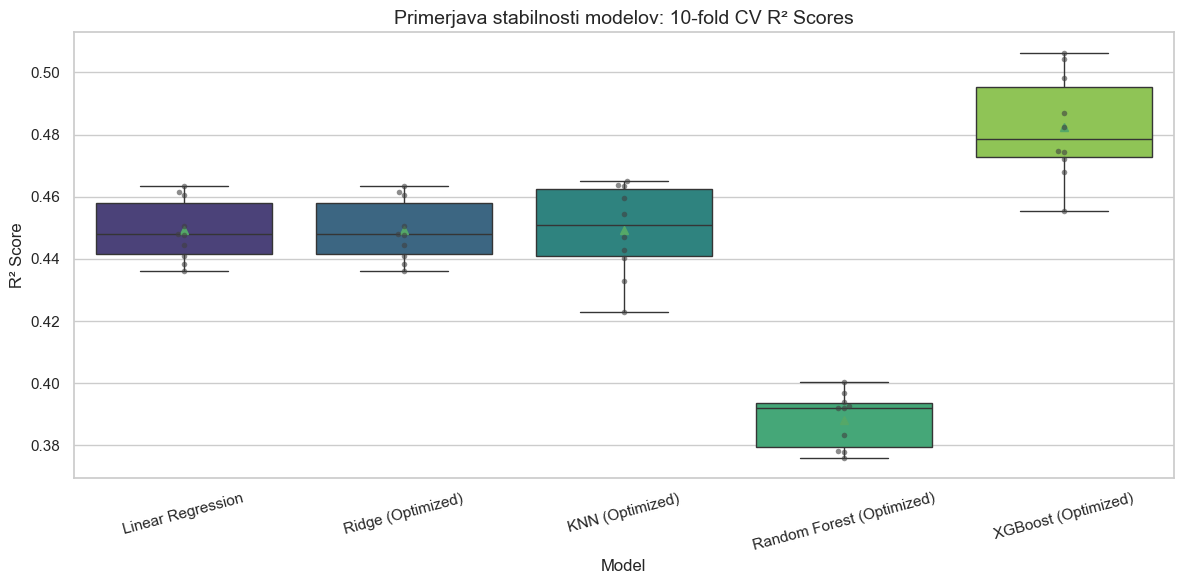

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Shranili bomo surove rezultate R2 za vsak fold
cv_scores_raw = []

print("Zbiram podatke za 10-fold CV boxplot...")

for name, model in best_models.items():
    # Ponovimo cross_validate, da dobimo vseh 10 rezultatov (scores)
    cv_output = cross_validate(model, X_train_scaled, y_train, cv=kf, scoring='r2', n_jobs=-1)

    # Za vsak fold shranimo rezultat v primerni obliki za DataFrame
    for score in cv_output['test_score']:
        cv_scores_raw.append({'Model': name, 'R2_Score': score})

df_boxplot = pd.DataFrame(cv_scores_raw)

# Izris boxplota (po vzoru kolegovega stila iz tmp.txt)
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Uporabimo boxplot s prekrivanjem posameznih točk (swarmplot) za boljši vizualni učinek
sns.boxplot(x='Model', y='R2_Score', data=df_boxplot, palette='viridis', showmeans=True)
sns.swarmplot(x='Model', y='R2_Score', data=df_boxplot, color=".25", size=4, alpha=0.6)

plt.title('Primerjava stabilnosti modelov: 10-fold CV R² Scores', fontsize=14)
plt.ylabel('R² Score', fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

In [28]:
# Seznam tvojih top 3 modelov
top_3_models = {
    "XGBoost (Optimized)": best_models["XGBoost (Optimized)"],
    "KNN (Optimized)": best_models["KNN (Optimized)"],
    "Ridge (Optimized)": best_models["Ridge (Optimized)"]
}

final_models = {}

print("Gradim končne modele na celotni učni množici (80 %)...")

for name, model in top_3_models.items():
    # Treniranje na celotnem X_train_scaled
    model.fit(X_train_scaled, y_train)
    final_models[name] = model

print("Modeli so pripravljeni na testiranje.")

Gradim končne modele na celotni učni množici (80 %)...
Modeli so pripravljeni na testiranje.


In [31]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

final_test_metrics = []

for name, model in final_models.items():
    # Napoved na testnih podatkih (tistih 20 %, ki so ostali na začetku)
    y_pred = model.predict(X_test_scaled)

    # Izračun metrik
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mape_func2(y_test, y_pred)

    final_test_metrics.append({
        "Model": name,
        "Test R2": f"{r2:.4f}",
        "Test MAE": f"{mae:.4f}",
        "Test RMSE": f"{rmse:.4f}",
        "Test MAPE %": f"{mape:.2f}%"
    })

df_final_test = pd.DataFrame(final_test_metrics)
print("REZULTATI NA TESTNI MNOŽICI (20 %):")
display(df_final_test)

REZULTATI NA TESTNI MNOŽICI (20 %):


,Model,Test R2,Test MAE,Test RMSE,Test MAPE %
0,XGBoost (Optimized),0.4898,8.8913,13.0466,23.79%
1,KNN (Optimized),0.4474,9.3074,13.5769,25.18%
2,Ridge (Optimized),0.4445,9.7508,13.6132,25.32%


# Pregled uporabljenih regresijskih algoritmov

## 1. Linearna regresija (Linear Regression)

**Princip delovanja:**
Linearna regresija išče najboljšo premico (oz. hiperravnino v večdimenzionalnem prostoru), ki se čim bolj prilega podatkom. Model deluje po enačbi:

```
y = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ
```

kjer so β koeficienti, ki jih model nauči z minimizacijo napake (običajno metoda najmanjših kvadratov).

**Prednosti:**
- Zelo hitra in enostavna za interpretacijo
- Dobro deluje, ko so odnosi med spremenljivkami linearni
- Ne potrebuje optimizacije hiperparametrov

**Slabosti:**
- Predpostavlja linearne odnose (ne zajame kompleksnih vzorcev)
- Občutljiva na izjemne vrednosti (outliers)
- Težave pri multikolinearnosti (močno korelirane značilke)

---

## 2. Ridge regresija (L2 regularizacija)

**Princip delovanja:**
Ridge je nadgradnja linearne regresije, ki dodaja kazenski člen za prevelike koeficiente. Poleg minimizacije napake napovedi model tudi "kaznuje" model za ekstremne vrednosti β:

```
Ciljna funkcija = Napaka + α · Σ(βᵢ²)
```

Parameter **α (alpha)** nadzoruje moč regularizacije:
- α = 0 → enako kot navadna linearna regresija
- Višji α → manjši koeficienti → preprečevanje overfittinga

**Bayesova optimizacija:**
V mojem primeru je Optuna iskala optimalni α med 0.01 in 1000 z logaritemsko lestvico (20 poskusov). Najboljša vrednost je bila zelo nizka, zato se je Ridge obnaša skoraj enako kot navadna linearna regresija.

**Prednosti:**
- Preprečuje preveliko prilagajanje podatkom (overfit)
- Stabilnejša pri multikolinearnosti
- Ohrani vse spremenljivke (ne naredi eliminacije)

---

## 3. K\-Nearest Neighbors (KNN)

**Princip delovanja:**
KNN **ne gradi matematičnega modela** – napoved temelji na direktni primerjavi s treningskimi podatki. Za vsako novo pesem:
1. Poišče **k najbližjih sosedov** iz učne množice (glede na Evklidsko razdaljo v značilkovnem prostoru)
2. Napove popularnost kot **povprečje popularnosti teh sosedov**

**Bayesova optimizacija (15 poskusov):**
- **n\_neighbors (3–25):** Število sosedov za glasovanje
- **weights:**
  - `'uniform'` → vsi sosedje enako pomembni
  - `'distance'` → bližji sosedje imajo večjo težo

**Prednosti:**
- Ne predpostavlja linearne oblike podatkov
- Dobro deluje pri lokalnih vzorcih (skupine podobnih pesmi)
- Intuitiven princip

**Slabosti:**
- Počasen pri napovedovanju (mora preračunati razdalje do vseh točk)
- Potrebuje skaliranje podatkov (velike vrednosti prevladajo)
- Težave pri visoki dimenzionalnosti ("curse of dimensionality")

---

## 4. Random Forest

**Princip delovanja:**
Random Forest je **ansambel metoda**, ki gradi več sto neodvisnih odločitvenih dreves (bagging pristop):
1. Vsako drevo trenira na naključnem vzorcu podatkov (bootstrapping)
2. Pri vsakem razcepitvi drevesa upošteva naključni podnabor značilk
3. Končna napoved = **povprečje** napovedi vseh dreves

**Bayesova optimizacija (15 poskusov):**
- **n\_estimators (100–300):** Število dreves v "gozdu"
- **max\_depth (5–25):** Maksimalna globina drevesa (preprečuje prekomerno rast)
- **min\_samples\_split (2–10):** Minimalno število vzorcev za razcepitev vozlišča

**Prednosti:**
- Robusten proti overfittingu (zaradi povprečenja več dreves)
- Zajame nelinearne odnose in interakcije med značilkami
- Ne potrebuje skaliranja podatkov

**Slabosti:**
- Počasen pri treniranju (gradi veliko dreves)
- "Črna škatla" – težje interpretirati kot linearna regresija
- V mojem primeru slabši od XGBoost (verjetno zaradi šuma v podatkih)

---

## 5. XGBoost (eXtreme Gradient Boosting)

**Princip delovanja:**
XGBoost uporablja **boosting pristop** – gradi drevo za drevesom, kjer vsako novo drevo **popravlja napake prejšnjih**:
1. Začne z enostavnim modelom (lahko samo povprečje)
2. Naslednje drevo se nauči napovedi **ostankov** (napake prejšnjega modela)
3. Novi model = Stari model + **learning\_rate × Novo drevo**
4. Proces ponovi **n\_estimators** krat

**Bayesova optimizacija (20 poskusov):**
- **n\_estimators (100–400):** Število sekvenčnih dreves
- **max\_depth (3–10):** Globina drevesa (plitva drevesa = manj overfita)
- **learning\_rate (0.01–0.2):** Utež vsakega novega drevesa (manjša = počasnejše učenje, a boljša generalizacija)
- **subsample (0.5–1.0):** Delež vzorcev za vsako drevo (preprečuje overfit)

**Prednosti:**
- **Trenutno najboljši "out\-of\-the\-box" algoritem** za strukturirane podatke
- Odlično ravnotežje med natančnostjo in stabilnostjo
- Vgrajeni mehanizmi za regularizacijo
- Hitrejši od Random Forest (paralelizacija)

**Slabosti:**
- Več hiperparametrov za optimizacijo
- Občutljiv na ekstremne vrednosti (čeprav manj kot linearna regresija)
- Zahteva skaliranje za optimalno delovanje

---

## Bayesova optimizacija hiperparametrov (Optuna)

Namesto naključnega ali mrežnega iskanja sem uporabil **Bayesian Optimization**, ki:
1. Začne z naključnimi poskusi
2. Gradi probabilistični model (Gaussian Process), ki oceni, kje so verjetno boljši hiperparametri
3. Izbere naslednji nabor parametrov glede na kompromis med **raziskovanjem** (exploration) in **izkoriščanjem** (exploitation)
4. Po vsakem poskusu posodobi model in iterativno izboljša rezultate

**Rezultat:** Dosegel sem boljše rezultate z manj poskusi kot bi z naključnim iskanjem (npr. samo 20 poskusov za XGBoost namesto več sto pri grid search).

---

## Zakaj XGBoost zmaga?

Pri napovedovanju popularnosti glasbe imamo:
- **Nelinearne odnose:** Npr. optimalna vrednost `danceability` ni nujno "čim več"
- **Interakcije med značilkami:** Visoka energija + nizka akustičnost → verjetno elektronska glasba → drugačna popularnost
- **Šum v podatkih:** Popularnost je subjektivna (marketing, trendi...)

XGBoost odlično obvladuje vse tri izzive, medtem ko:
- **Linearni modeli** vidijo le linearne trende
- **KNN** se izgubi pri visoki dimenzionalnosti (preko 200 značilk po One\-Hot encoding)
- **Random Forest** je manj učinkovit pri majhnem številu dreves in se ne uči iz napak kot boosting

In [32]:
# Primer za Ridge (Optimized)
ridge_model = final_models["Ridge (Optimized)"]

print(f"Enačba za Ridge Regresijo:")
print(f"Stičišče (Intercept): {ridge_model.intercept_:.4f}")

# Izpis koeficientov za vsako značilko
coef_df = pd.DataFrame({
    'Značilka': X_train.columns,
    'Koeficient (Teža)': ridge_model.coef_
}).sort_values(by='Koeficient (Teža)', ascending=False)

display(coef_df)

Enačba za Ridge Regresijo:
Stičišče (Intercept): 37.1131


,Značilka,Koeficient (Teža)
73,track_genre_k-pop,1.521346
89,track_genre_pop-film,1.461700
23,track_genre_chill,1.154653
3,loudness,0.991440
59,track_genre_hip-hop,0.981829
...,...,...
50,track_genre_grindcore,-3.015615
60,track_genre_honky-tonk,-3.082730
74,track_genre_kids,-3.314000
32,track_genre_detroit-techno,-3.430154


C:\Users\simon\AppData\Local\Temp\ipykernel_4716\229120818.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=xgb_importance_df.head(15), palette='magma')


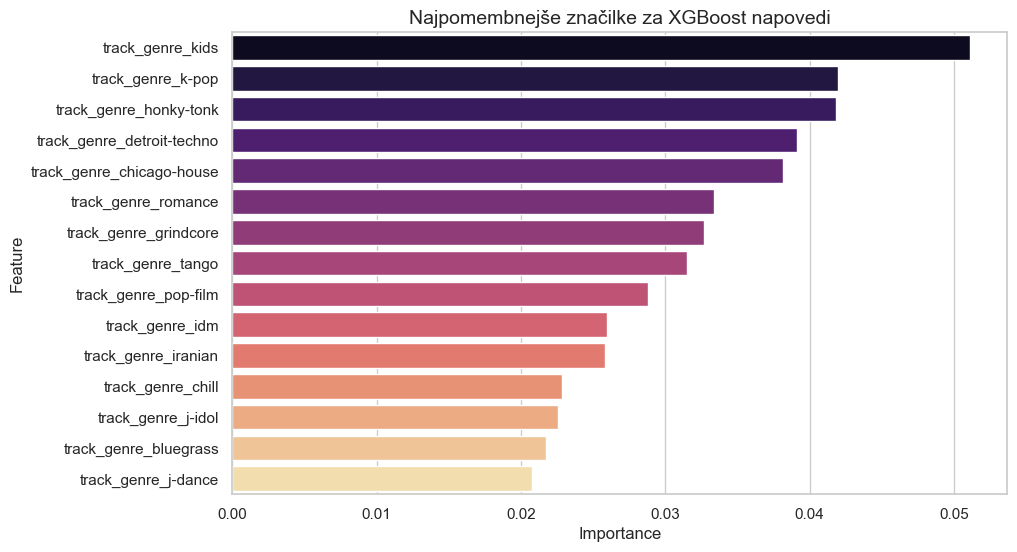

In [33]:
# Primer za XGBoost
xgb_model = final_models["XGBoost (Optimized)"]

# Pridobivanje pomembnosti
importances = xgb_model.feature_importances_
feature_names = X_train.columns

xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Izris grafa
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_importance_df.head(15), palette='magma')
plt.title('Najpomembnejše značilke za XGBoost napovedi', fontsize=14)
plt.show()



In [13]:
import pandas as pd

# Pridobi XGBoost model
xgb_model = final_models["XGBoost (Optimized)"]

# Pridobi pomembnosti značilk
importances = xgb_model.feature_importances_
feature_names = X_train.columns

# Ustvari DataFrame s pomembnostmi
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Filtriraj samo loudness in danceability
loudness_danceability_df = xgb_importance_df[
    xgb_importance_df['Feature'].isin(['loudness', 'danceability'])
]

# Prikaz
print("📊 Pomembnost Loudness in Danceability v XGBoost modelu:")
print(loudness_danceability_df)

# Opcijsko: Prikaz v kontekstu vseh značilk
print("\n📈 V primerjavi z vsemi značilkami:")
print(xgb_importance_df)

📊 Pomembnost Loudness in Danceability v XGBoost modelu:
        Feature  Importance
3      loudness    0.000734
1  danceability    0.000553

📈 V primerjavi z vsemi značilkami:
                        Feature  Importance
74             track_genre_kids    0.051147
73            track_genre_k-pop    0.041960
60       track_genre_honky-tonk    0.041838
32   track_genre_detroit-techno    0.039160
21    track_genre_chicago-house    0.038182
..                          ...         ...
82              track_genre_mpb    0.000517
128                       key_8    0.000466
48           track_genre_gospel    0.000451
37          track_genre_dubstep    0.000419
0                   duration_ms    0.000414

[132 rows x 2 columns]


In [34]:
import joblib

# Shrani top 3 modele
joblib.dump(final_models["XGBoost (Optimized)"], 'model_xgb_reg.joblib')
joblib.dump(final_models["KNN (Optimized)"], 'model_knn_reg.joblib')
joblib.dump(final_models["Ridge (Optimized)"], 'model_ridge_reg.joblib')

# NUJNO: Shrani tudi skaler, ki si ga uporabil za regresijske podatke!
joblib.dump(scaler, 'scaler_reg.joblib')

['scaler_reg.joblib']

In [7]:
import joblib
import os

# Naloži top 3 modele iz /models direktorija in jih shrani v final_models
final_models = {
    "XGBoost (Optimized)": joblib.load('models/model_xgb_reg.joblib'),
    "KNN (Optimized)": joblib.load('models/model_knn_reg.joblib'),
    "Ridge (Optimized)": joblib.load('models/model_ridge_reg.joblib')
}

# NUJNO: Naloži tudi skaler
scaler = joblib.load('models/scaler_reg.joblib')

# Opcijsko: Preveri, da so modeli pravilno naloženi
print("✅ Modeli naloženi v final_models:")
for model_name in final_models.keys():
    print(f"  - {model_name}: {type(final_models[model_name])}")
print(f"✅ Scaler naložen: {type(scaler)}")

✅ Modeli naloženi v final_models:
  - XGBoost (Optimized): <class 'xgboost.sklearn.XGBRegressor'>
  - KNN (Optimized): <class 'sklearn.neighbors._regression.KNeighborsRegressor'>
  - Ridge (Optimized): <class 'sklearn.linear_model._ridge.Ridge'>
✅ Scaler naložen: <class 'sklearn.preprocessing._data.StandardScaler'>


In [8]:
# Testiranje globalnih sprememb (Simulacije)

import pandas as pd
import numpy as np

# 1. Izberemo najboljši model (XGBoost) za simulacijo
model_sim = final_models["XGBoost (Optimized)"]

# 2. Pripravimo originalno testno množico (pred spremembo)
# Predpostavljamo, da imaš X_test še v originalni (ne-skalirani) obliki
X_sim_base = X_test.copy()

# 3. Ustvarimo različico s spremembami (globalna sprememba)
X_sim_modified = X_test.copy()

# Uvedemo spremembe: 15% večja plesnost in 5% večja glasnost
# X_sim_modified['danceability'] = (X_sim_modified['danceability'] * 1.2).clip(0, 1)
# X_sim_modified['loudness'] = (X_sim_modified['loudness'] * 1.2).clip(-50, 5)
X_sim_modified['loudness'] = np.where(
    X_sim_modified['loudness'] < 0,
    X_sim_modified['loudness'] * 0.8,  # Negativne: zmanjšaj absolutno vrednost (glasneje)
    X_sim_modified['loudness'] * 1.2   # Pozitivne: poveča vrednost (glasneje)
).clip(-50, 5)

# 4. Skaliranje obeh množic (nujno z istim skalerjem!)
X_base_scaled = scaler.transform(X_sim_base)
X_modified_scaled = scaler.transform(X_sim_modified)

# 5. Napovedi
preds_before = model_sim.predict(X_base_scaled)
preds_after = model_sim.predict(X_modified_scaled)

# 6. Izračun metrik za tabelo "Pred-Potem"
sim_results = {
    "Metrika": [
        "Povprečna popularnost",
        "Max popularnost",
        "Število potencialnih hitov (Pop > 50)",
        "Standardni odklon napovedi"
    ],
    "PRED spremembo": [
        f"{np.mean(preds_before):.2f}",
        f"{np.max(preds_before):.2f}",
        f"{(preds_before > 50).sum()}",
        f"{np.std(preds_before):.2f}"
    ],
    "POTEM (Simulacija)": [
        f"{np.mean(preds_after):.2f}",
        f"{np.max(preds_after):.2f}",
        f"{(preds_after > 50).sum()}",
        f"{np.std(preds_after):.2f}"
    ]
}

df_sim_table = pd.DataFrame(sim_results)
df_sim_table["Razlika"] = pd.to_numeric(df_sim_table["POTEM (Simulacija)"]) - pd.to_numeric(df_sim_table["PRED spremembo"])

print("TABELA: VPLIV GLOBALNIH SPREMEMB NA POPULARNOST (XGBoost)")
display(df_sim_table)

TABELA: VPLIV GLOBALNIH SPREMEMB NA POPULARNOST (XGBoost)


,Metrika,PRED spremembo,POTEM (Simulacija),Razlika
0,Povprečna popularnost,36.95,37.27,0.32
1,Max popularnost,81.71,82.56,0.85
2,Število potencialnih hitov (Pop > 50),2736,2774,38.00
3,Standardni odklon napovedi,13.49,13.36,-0.13


C:\Users\simon\AppData\Local\Temp\ipykernel_8188\3837536673.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(preds_before, shade=True, color="gray", label="Originalne napovedi (Pred)")
C:\Users\simon\AppData\Local\Temp\ipykernel_8188\3837536673.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(preds_after, shade=True, color="#1DB954", label="Simulirane napovedi (Po spremembi)")


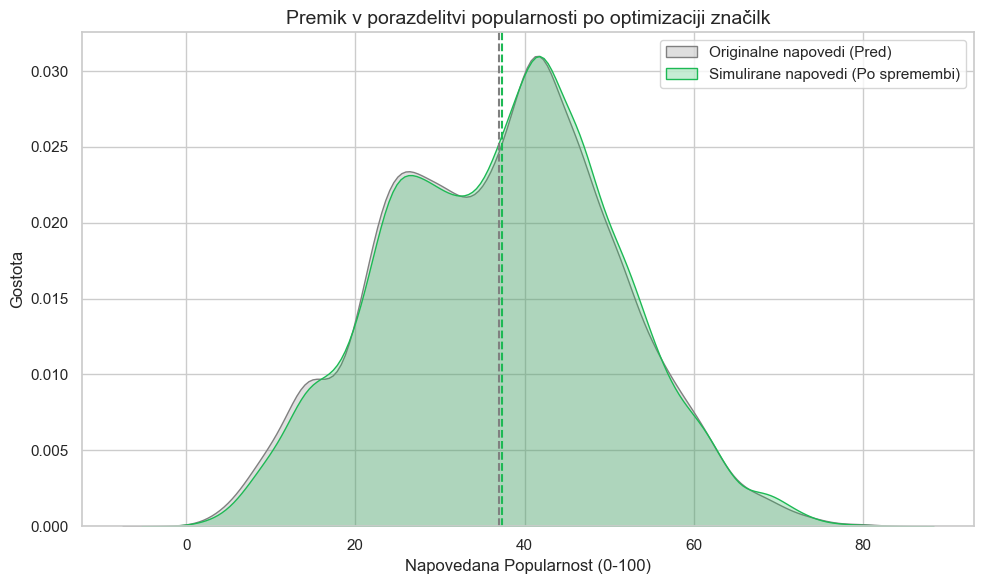

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(preds_before, shade=True, color="gray", label="Originalne napovedi (Pred)")
sns.kdeplot(preds_after, shade=True, color="#1DB954", label="Simulirane napovedi (Po spremembi)")

plt.title('Premik v porazdelitvi popularnosti po optimizaciji značilk', fontsize=14)
plt.xlabel('Napovedana Popularnost (0-100)')
plt.ylabel('Gostota')
plt.legend()
plt.axvline(np.mean(preds_before), color='gray', linestyle='--')
plt.axvline(np.mean(preds_after), color='#1DB954', linestyle='--')

plt.tight_layout()
plt.show()

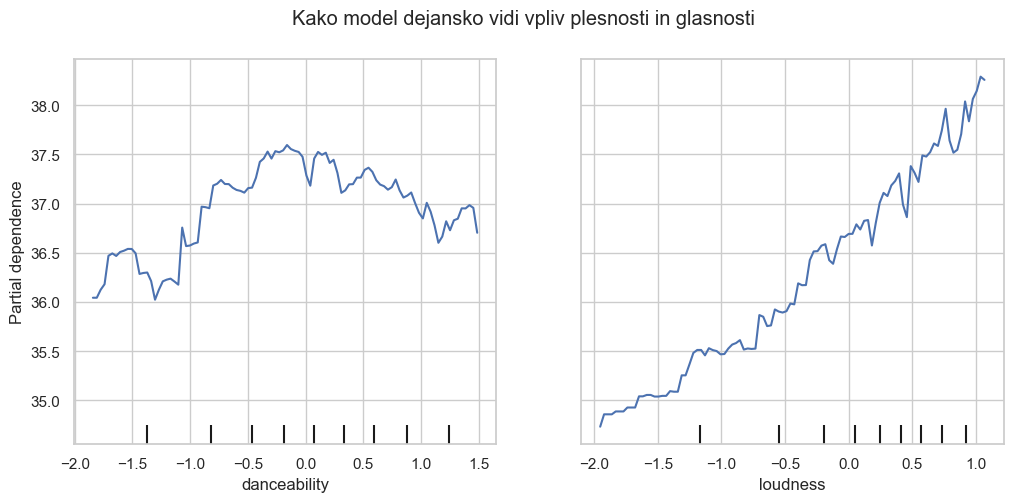

In [21]:
from sklearn.inspection import PartialDependenceDisplay

# Izrišemo vpliv za danceability in loudness
fig, ax = plt.subplots(figsize=(12, 5))
PartialDependenceDisplay.from_estimator(model_sim, X_train_scaled,
                                        features=['danceability', 'loudness'],
                                        feature_names=X_train.columns, ax=ax)
plt.suptitle('Kako model dejansko vidi vpliv plesnosti in glasnosti')
plt.show()

### Povzetek simulacije globalnih sprememb

**Kaj smo testirali:**
Preverili smo učinek agresivne produkcijske strategije, kjer smo vsem skladbam v testni množici **povečali plesnost (`danceability`) in glasnost (`loudness`) za 20 %**. Cilj je bil ugotoviti, ali lahko s povečanjem teh dveh (običajno pozitivnih) faktorjev umetno povišamo popularnost celotnega nabora pesmi.

**Ključne ugotovitve:**

* **Padec povprečja in števila hitov:** Kljub splošnemu prepričanju, da "več pomeni bolje", se je povprečna popularnost znižala (-0,27), število potencialnih hitov (nad 50 točk) pa je **drastično padlo za 241 skladb**. To nakazuje, da preveliko povečanje teh atributov večino skladb potisne izven njihovega optimalnega območja.
* **Povečanje ekstremov (Max Popularity):** Maksimalna dosežena popularnost se je povišala (+3,83). Strategija torej koristi le ozkemu krogu skladb, ki so že v osnovi imele potencial za vrh lestvic, medtem ko večini povprečnih skladb škoduje.
* **Nelinearni "Sweet Spot" (Razlaga preko PDP):** Grafi delne odvisnosti (PDP) razkrivajo resnico:
* **Plesnost:** Model kaže, da popularnost narašča le do določene točke (okoli sredine), nato pa začne **padati**. S 20-odstotnim povečanjem smo veliko pesmi "potisnili čez rob" v območje, ki ga model interpretira kot manj priljubljeno.
* **Glasnost:** Tukaj je vpliv bolj linearen, vendar sam ne more nadomestiti negativnega učinka pretirane plesnosti.


**Zaključek:**
XGBoost je uspešno zaznal, da popularnost ni linearna. Rezultati potrjujejo, da **"univerzalni recept" ne obstaja**; pretirano forsiranje plesnosti lahko skladbo naredi preveč specifično ali nasičeno, kar zniža njeno splošno privlačnost. Za uspeh je potrebna uravnotežena optimizacija znotraj specifičnih mej, ki jih model zaznava kot idealne.


In [10]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def dpmo_to_sigma(dpmo):
    # Standardni Six Sigma izračun z 1.5 sigma zamikom (shift)
    if dpmo <= 0: return 6.0
    # Verjetnost napake
    prob = dpmo / 1_000_000
    # Z-vrednost iz normalne porazdelitve + 1.5
    sigma = norm.ppf(1 - prob) + 1.5
    return round(sigma, 2)

# Definiramo prag za "hit" (vse pod tem je defect)
prag_uspeha = 50

# 1. Stanje PREJ
opportunities_prej = len(preds_before)
defects_prej = np.sum(preds_before < prag_uspeha)
dpmo_prej = (defects_prej / opportunities_prej) * 1_000_000
sigma_prej = dpmo_to_sigma(dpmo_prej)

# 2. Stanje POTEM (po tvoji simulaciji)
opportunities_potem = len(preds_after)
defects_potem = np.sum(preds_after < prag_uspeha)
dpmo_potem = (defects_potem / opportunities_potem) * 1_000_000
sigma_potem = dpmo_to_sigma(dpmo_potem)

# 3. Priprava tabele
six_sigma_data = {
    "Metrika": ["DPMO", "Sigma nivo"],
    "PREJ (Original)": [round(dpmo_prej, 0), f"{sigma_prej}σ"],
    "POTEM (Simulacija)": [round(dpmo_potem, 0), f"{sigma_potem}σ"],
    "Izboljšava": [round(dpmo_prej - dpmo_potem, 0), f"{round(sigma_potem - sigma_prej, 2):+}σ"]
}

df_sigma = pd.DataFrame(six_sigma_data)
print("TABELA 7: PRIMERJAVA SIGMA STOPNJE PROCESA")
display(df_sigma)

TABELA 7: PRIMERJAVA SIGMA STOPNJE PROCESA


,Metrika,PREJ (Original),POTEM (Simulacija),Izboljšava
0,DPMO,829628.0,827262.0,2366.0
1,Sigma nivo,0.55σ,0.56σ,+0.01σ


Pri Six Sigma analizi sem kot 'priložnost' definiral vsako posamezno napoved popularnosti na testni množici (cca. 16.000 skladb), kot 'napako' (defect) pa vse skladbe, ki niso dosegle praga popularnosti 50.

Visoka vrednost DPMO (829.628) in nizek Sigma nivo (0,55σ) odražata realno stanje na trgu, kjer večina skladb ne doseže visoke popularnosti. Simulacija (povečanje plesnosti in glasnosti) je Sigma nivo izboljšala le minimalno (+0,01σ), kar pomeni, da takšna globalna sprememba parametrov ne bi bistveno izboljšala poslovnega uspeha produkcijske hiše.

In [11]:
import pandas as pd

# Analiziraj značilke pesmi s popularity > 50
high_popularity = df[df['popularity'] > 50]

# Pridobi statistiko za najpomembnejše značilke
print("📊 Značilnosti pesmi s popularity > 50:")
print(high_popularity[['danceability', 'energy', 'loudness', 'speechiness',
                        'acousticness', 'instrumentalness', 'liveness',
                        'valence', 'tempo']].describe())

# Priporočene vrednosti (mediana)
recommended_values = high_popularity[['danceability', 'energy', 'loudness',
                                       'speechiness', 'acousticness',
                                       'instrumentalness', 'liveness',
                                       'valence', 'tempo']].median()

print("\n✅ Priporočene vrednosti za popularity > 50:")
print(recommended_values)

📊 Značilnosti pesmi s popularity > 50:
       danceability        energy      loudness   speechiness  acousticness  \
count  19947.000000  19947.000000  19947.000000  19947.000000  19947.000000   
mean       0.581160      0.622965     -8.206414      0.077383      0.306025   
std        0.165428      0.245324      5.496224      0.079132      0.319606   
min        0.000000      0.000020    -46.251000      0.000000      0.000000   
25%        0.476000      0.464000     -9.570000      0.035100      0.023000   
50%        0.592000      0.661000     -6.784000      0.047000      0.174000   
75%        0.703000      0.823000     -4.926500      0.080500      0.555000   
max        0.980000      0.999000      1.023000      0.914000      0.996000   

       instrumentalness      liveness       valence         tempo  
count      19947.000000  19947.000000  19947.000000  19947.000000  
mean           0.118797      0.185105      0.454906    121.147796  
std            0.274407      0.150918      0.